In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import colorsys
import numpy as np
import networkx as nx

from hierarhical import hierarchical_lance_williams
from hierarhical import merging_avg_coefs, merging_centroid_coefs, merging_complete_coefs, merging_single_coefs, merging_ward_coefs

coefs = {
    'single': merging_single_coefs,
    'centroid': merging_centroid_coefs,
    'avg': merging_avg_coefs,
    'complete': merging_complete_coefs,
    'ward': merging_ward_coefs
}

def rgb_to_cmyk_array(rgb_array):
    cmyk_array = np.zeros((rgb_array.shape[0], 4))
    
    for i, (r, g, b) in enumerate(rgb_array):
        k = 1 - max(r, g, b)
        
        if k < 1:
            c = (1 - r - k) / (1 - k)
            m = (1 - g - k) / (1 - k)
            y = (1 - b - k) / (1 - k)
        else:
            c = 0
            m = 0
            y = 0
        cmyk_array[i] = [c, m, y, k]
    return cmyk_array


node_colorss_w = {}
node_colorss_uw = {}

def gen_rev_padre(padre):
    rev_padre = {}
    for i, p in enumerate(padre):
        if p != -1:
            if p not in rev_padre:
                rev_padre[p] = []
            rev_padre[p].append(i)
    return rev_padre


def gen_node_colors_weighted(rev_padre, root, node_arr):
    node_colors = {}
    def dfs(node):
        if node not in rev_padre:
            node_colors[node] = node_arr[node]
            return node_arr[node], 1
        res = []
        weights = []
        for child in rev_padre[node]:
            col, w = dfs(child)
            res.append(col)
            weights.append(w)
        
        res = np.average(res, axis=0, weights=weights)
        node_colors[node] = res
        return res, sum(weights)
    
    dfs(root)
    return node_colors

def gen_node_colors_unweighted(rev_padre, root, node_arr):
    node_colors = {}
    def dfs(node):
        if node not in rev_padre:
            node_colors[node] = node_arr[node]
            return node_arr[node]
        res = []
        for child in rev_padre[node]:
            col = dfs(child)
            res.append(col)
        
        res = np.average(res, axis=0)
        node_colors[node] = res
        return res
    
    dfs(root)
    return node_colors

    
def avg_color(c1, c2):
    return tuple([(c1[i] + c2[i]) / 2 for i in range(3)])

def gen_color_G(padre, node_arr, weighted=True):
    rev_padre = gen_rev_padre(padre)
    root = len(padre) - 1
    
    if weighted:
        node_colors = gen_node_colors_weighted(rev_padre, root, node_arr=node_arr)
    else:
        node_colors = gen_node_colors_unweighted(rev_padre, root, node_arr=node_arr)
        
    G = nx.DiGraph()
    
    for i, p in enumerate(padre):
        col = tuple(node_colors[i])
        col = tuple([c/255 for c in col])
        # print(col)
        G.add_node(i, color=col)
        
    for i, p in enumerate(padre):
        if p != -1:
            col = avg_color(G.nodes[p]['color'], G.nodes[i]['color'])
            # print(col)
            G.add_edge(p, i, color=col)
        
    return G


def gen_nice_trees(img_path, img_name, reshape_factor=0.01, fig_size=10, weighted=True):
    pdrs = {}
    lbls = {}
    
    img_raw = cv2.imread(img_path)
    img_compressed = cv2.resize(img_raw, (0, 0), fx=reshape_factor, fy=reshape_factor)
    img_arr = np.array(img_compressed).reshape(-1, 3)
    
    # reverse -> rgb to bgr
    img_arr = img_arr[:, [2, 1, 0]]
    print("size: ", img_arr.shape[0])
    
    node_arr = rgb_to_cmyk_array(img_arr)
    
    for i, c in enumerate(coefs.items()):
        coef_name, coef = c
        
        labels, padre = hierarchical_lance_williams(node_arr, 1, merging_coefs=coef)
        pdrs[coef_name] = padre
        lbls[coef_name] = labels
        print(f'done: {coef_name}')
        
    for i, c in enumerate(coefs.items()):
        fig = plt.figure()
        fig.set_size_inches(fig_size, fig_size)
        ax = fig.add_subplot(111, facecolor='white')
        fig.patch.set_facecolor('white')
        
        coef_name, coef = c
        
        G = gen_color_G(pdrs[coef_name], weighted=weighted, node_arr=img_arr)
        
        node_colors = [G.nodes[i]['color'] for i in G.nodes]
        edge_colors = [G.edges[e]['color'] for e in G.edges]
        
        pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
        nx.draw(G, pos, with_labels=False, arrows=False, node_size=10, ax=ax, node_color=node_colors, edge_color=edge_colors)
        
        # save each plot to a file
        plt.savefig(f'./../output/{img_name}_{coef_name}.png')
    

size:  208
done: single
done: centroid
done: avg
done: complete
done: ward


/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.16470588235294117, 0.17647058823529413, 0.3607843137254902) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.16470588235294117, 0.17647058823529413, 0.3607843137254902) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.16470588235294117, 0.17647058823529413, 0.3607843137254902) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.16470588235294117, 0.17647058823529413, 0.3607843137254902) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encodin

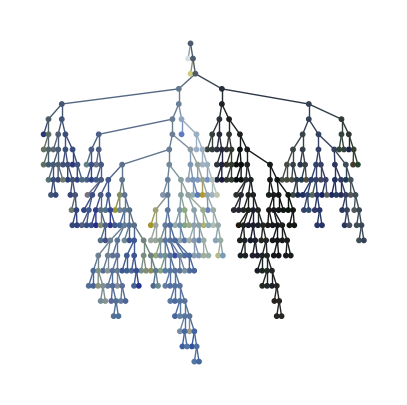

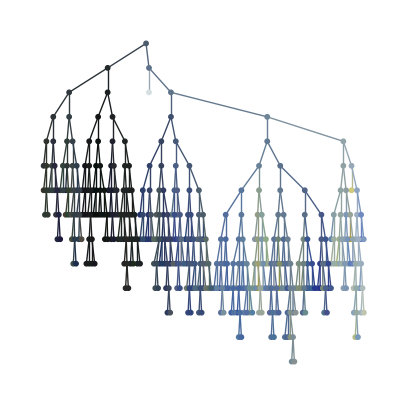

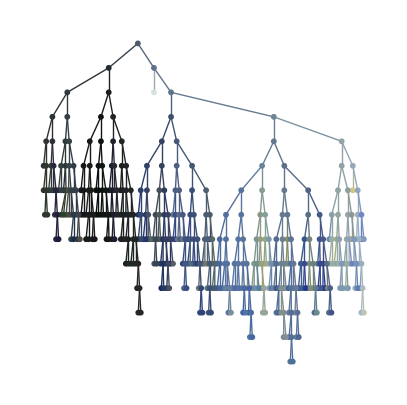

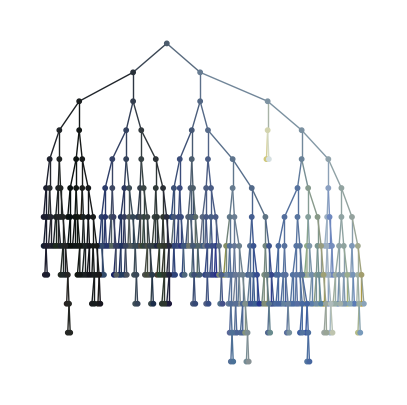

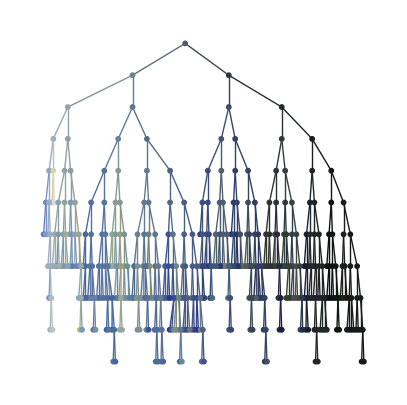

In [2]:
gen_nice_trees('./../data/starry_night.jpg', 'starry_night', reshape_factor=0.02, fig_size=5)

size:  81
done: single
done: centroid
done: avg
done: complete
done: ward


/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.6313725490196078, 0.0, 0.023529411764705882) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.6313725490196078, 0.0, 0.023529411764705882) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.6313725490196078, 0.0, 0.023529411764705882) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.6313725490196078, 0.0, 0.023529411764705882) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-pack

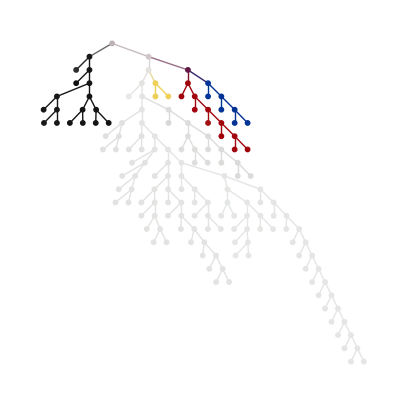

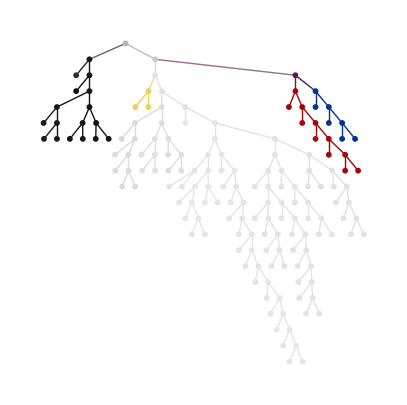

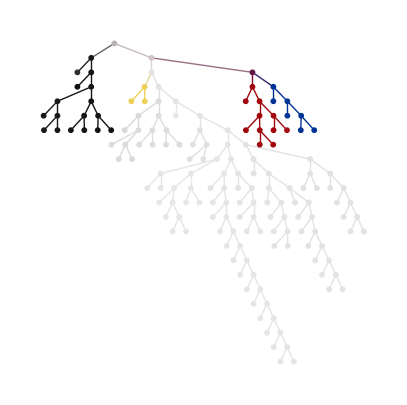

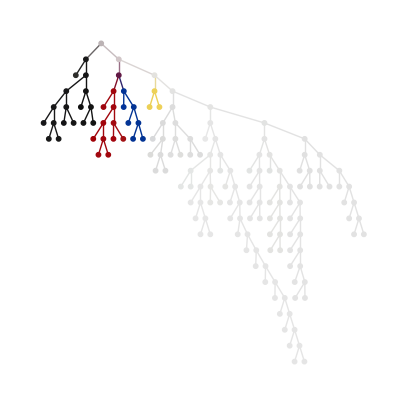

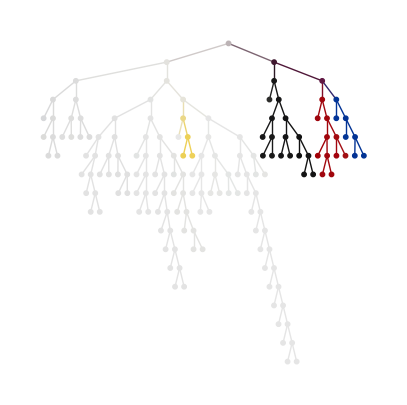

In [3]:
gen_nice_trees('./../data/mondrian.jpg', 'mondrian', reshape_factor=0.02, fig_size=5)

size:  270
done: single
done: centroid
done: avg
done: complete
done: ward


/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.5254901960784314, 0.48627450980392156, 0.5490196078431373) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.5254901960784314, 0.48627450980392156, 0.5490196078431373) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.5254901960784314, 0.48627450980392156, 0.5490196078431373) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.5254901960784314, 0.48627450980392156, 0.5490196078431373) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), 

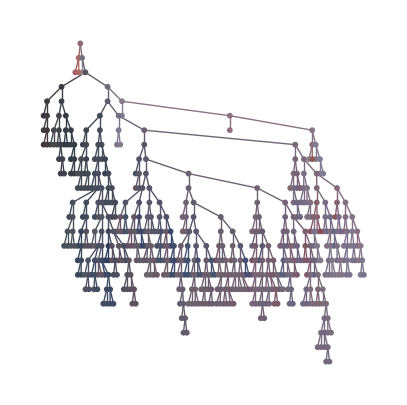

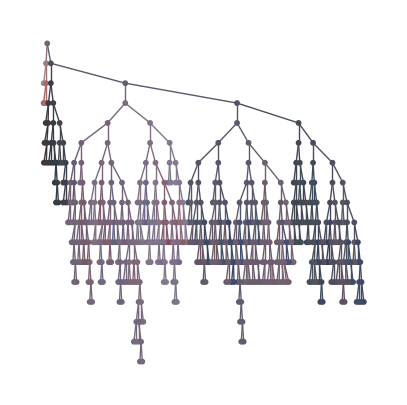

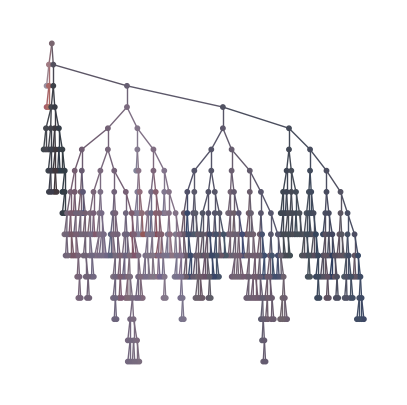

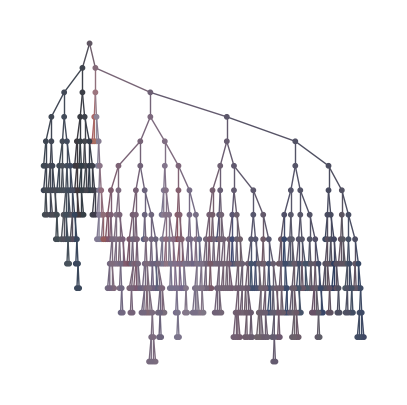

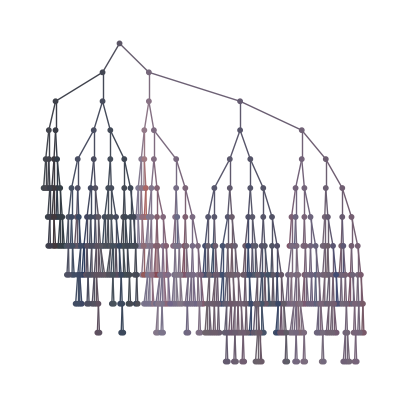

In [4]:
gen_nice_trees('./../data/london.jpg', 'london', reshape_factor=0.005, fig_size=5, weighted=False)

size:  304
done: single
done: centroid
done: avg
done: complete
done: ward


/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.12549019607843137, 0.09803921568627451, 0.03529411764705882) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.12549019607843137, 0.09803921568627451, 0.03529411764705882) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.12549019607843137, 0.09803921568627451, 0.03529411764705882) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.12549019607843137, 0.09803921568627451, 0.03529411764705882) is not a known color.

  warnings.warn(b"".join(errors).decode(self.enc

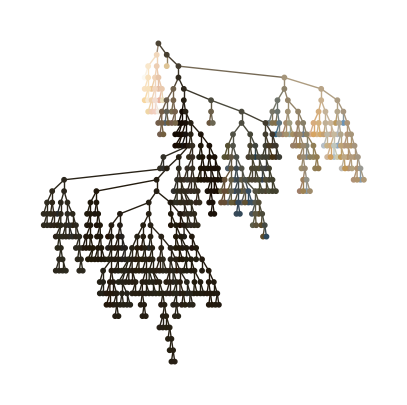

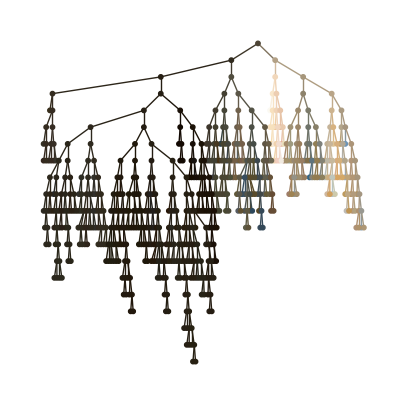

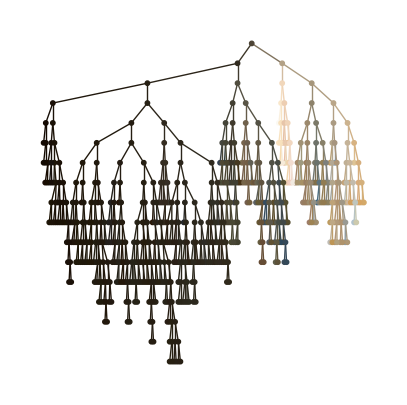

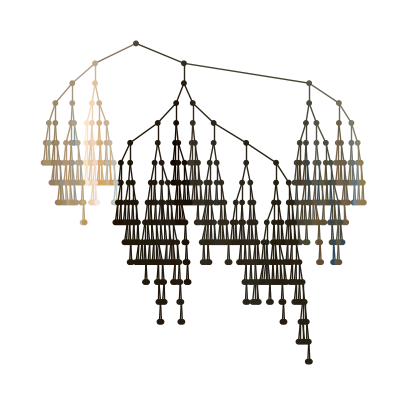

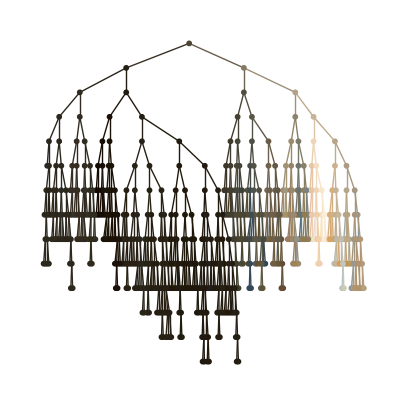

In [5]:
gen_nice_trees('./../data/girl_with_earring.jpg', 'girl_with_earring', reshape_factor=0.02, fig_size=5)

size:  247
done: single
done: centroid
done: avg
done: complete
done: ward


/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.4470588235294118, 0.5058823529411764, 0.3411764705882353) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.4470588235294118, 0.5058823529411764, 0.3411764705882353) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.4470588235294118, 0.5058823529411764, 0.3411764705882353) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/ts/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1409: RuntimeWarning: Warning: (0.4470588235294118, 0.5058823529411764, 0.3411764705882353) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), Runt

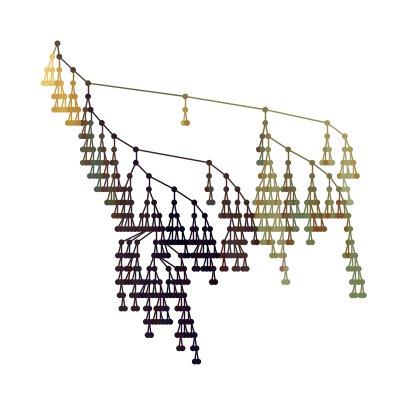

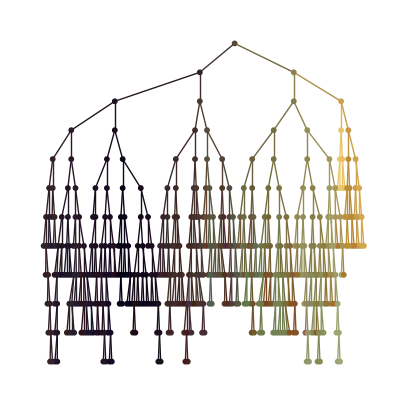

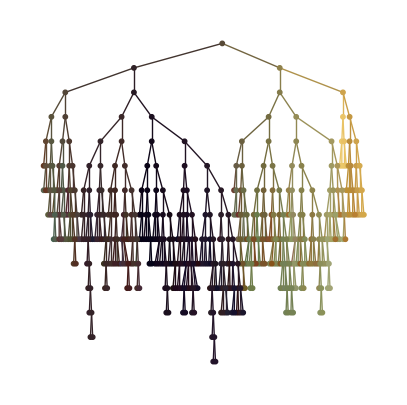

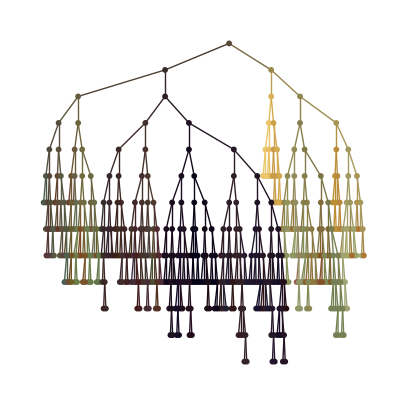

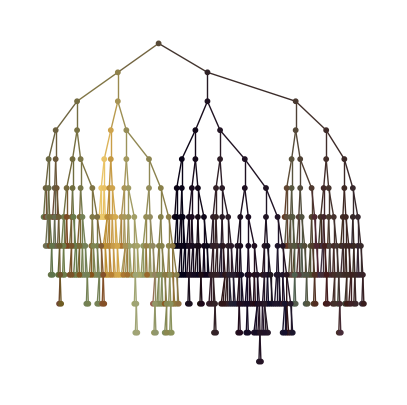

In [6]:
gen_nice_trees('./../data/mona_lisa.jpg', 'mona_lisa', reshape_factor=0.02, fig_size=5)

In [2]:
import warnings


def plot_nice_trees(img_path, img_name, reshape_factor=0.01, fig_size=10, weighted=True):
    
    warnings.filterwarnings("ignore")
    pdrs = {}
    lbls = {}
    
    img_raw = cv2.imread(img_path)
    img_compressed = cv2.resize(img_raw, (0, 0), fx=reshape_factor, fy=reshape_factor)
    img_arr = np.array(img_compressed).reshape(-1, 3)
    
    # reverse -> rgb to bgr
    img_arr = img_arr[:, [2, 1, 0]]
    print("size: ", img_arr.shape[0])
    
    node_arr = rgb_to_cmyk_array(img_arr)
    
    for i, c in enumerate(coefs.items()):
        coef_name, coef = c
        
        labels, padre = hierarchical_lance_williams(node_arr, 1, merging_coefs=coef)
        pdrs[coef_name] = padre
        lbls[coef_name] = labels
        print(f'done: {coef_name}')
    
    # Create a 3x2 grid for plots
    fig, axs = plt.subplots(3, 2, figsize=(fig_size*2, fig_size*3))
    
    # Plot the original image
    axs[0, 0].imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Original Image')
    
    for i, (coef_name, coef) in enumerate(coefs.items()):
        ax = axs[(i+1)//2, (i+1)%2]  # Grid placement
        ax.set_facecolor('white')
        
        G = gen_color_G(pdrs[coef_name], weighted=weighted, node_arr=img_arr)
        
        node_colors = [G.nodes[j]['color'] for j in G.nodes]
        edge_colors = [G.edges[e]['color'] for e in G.edges]
        
        pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
        nx.draw(G, pos, with_labels=False, arrows=False, node_size=10, ax=ax, node_color=node_colors, edge_color=edge_colors)
        ax.set_title(f'{coef_name}')
    
    plt.tight_layout()
    plt.show()


size:  270
done: single
done: centroid
done: avg
done: complete
done: ward


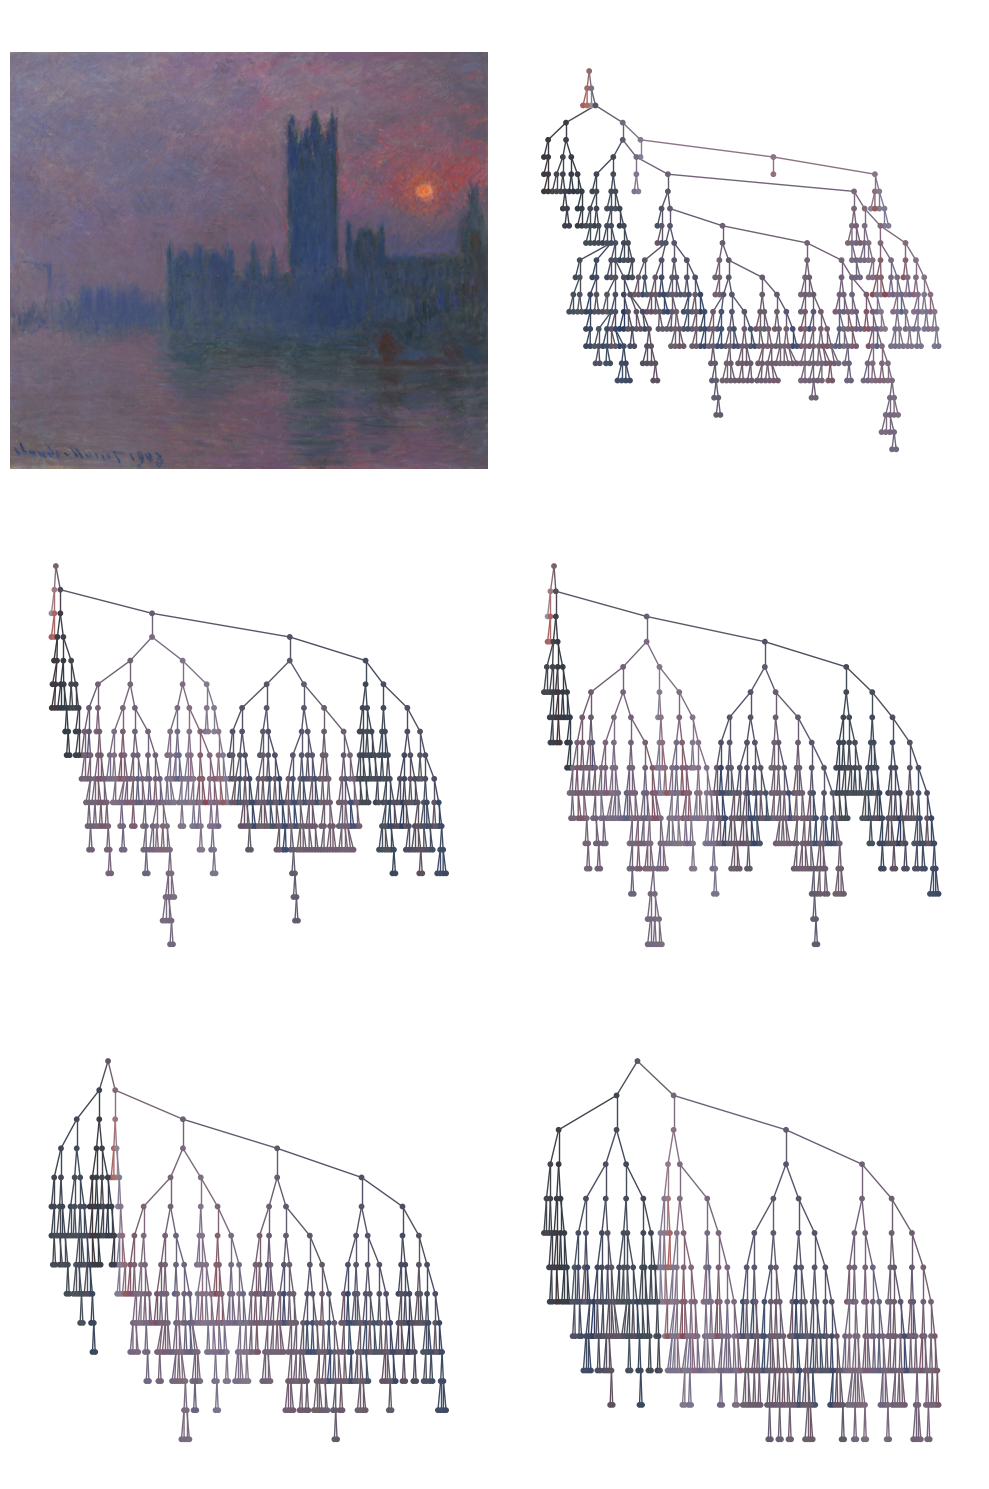

In [10]:
plot_nice_trees('./../data/london.jpg', 'london', reshape_factor=0.005, fig_size=5, weighted=False)

size:  304
done: single
done: centroid
done: avg
done: complete
done: ward


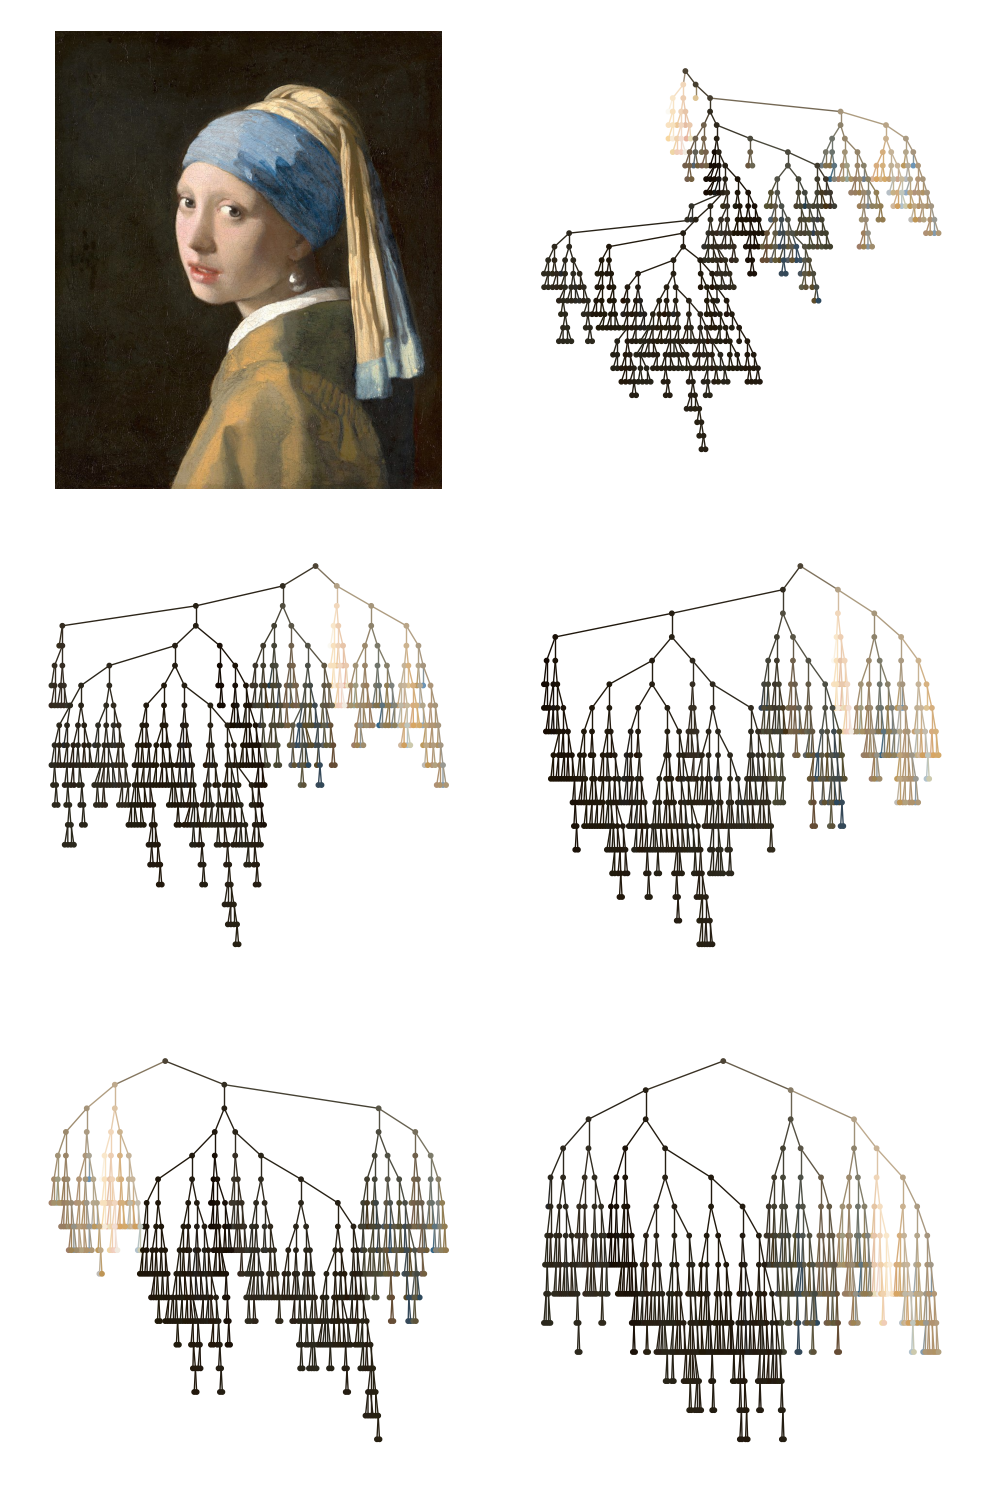

In [7]:
plot_nice_trees('./../data/girl_with_earring.jpg', 'girl', reshape_factor=0.02, fig_size=5)

size:  299
done: single
done: centroid
done: avg
done: complete
done: ward


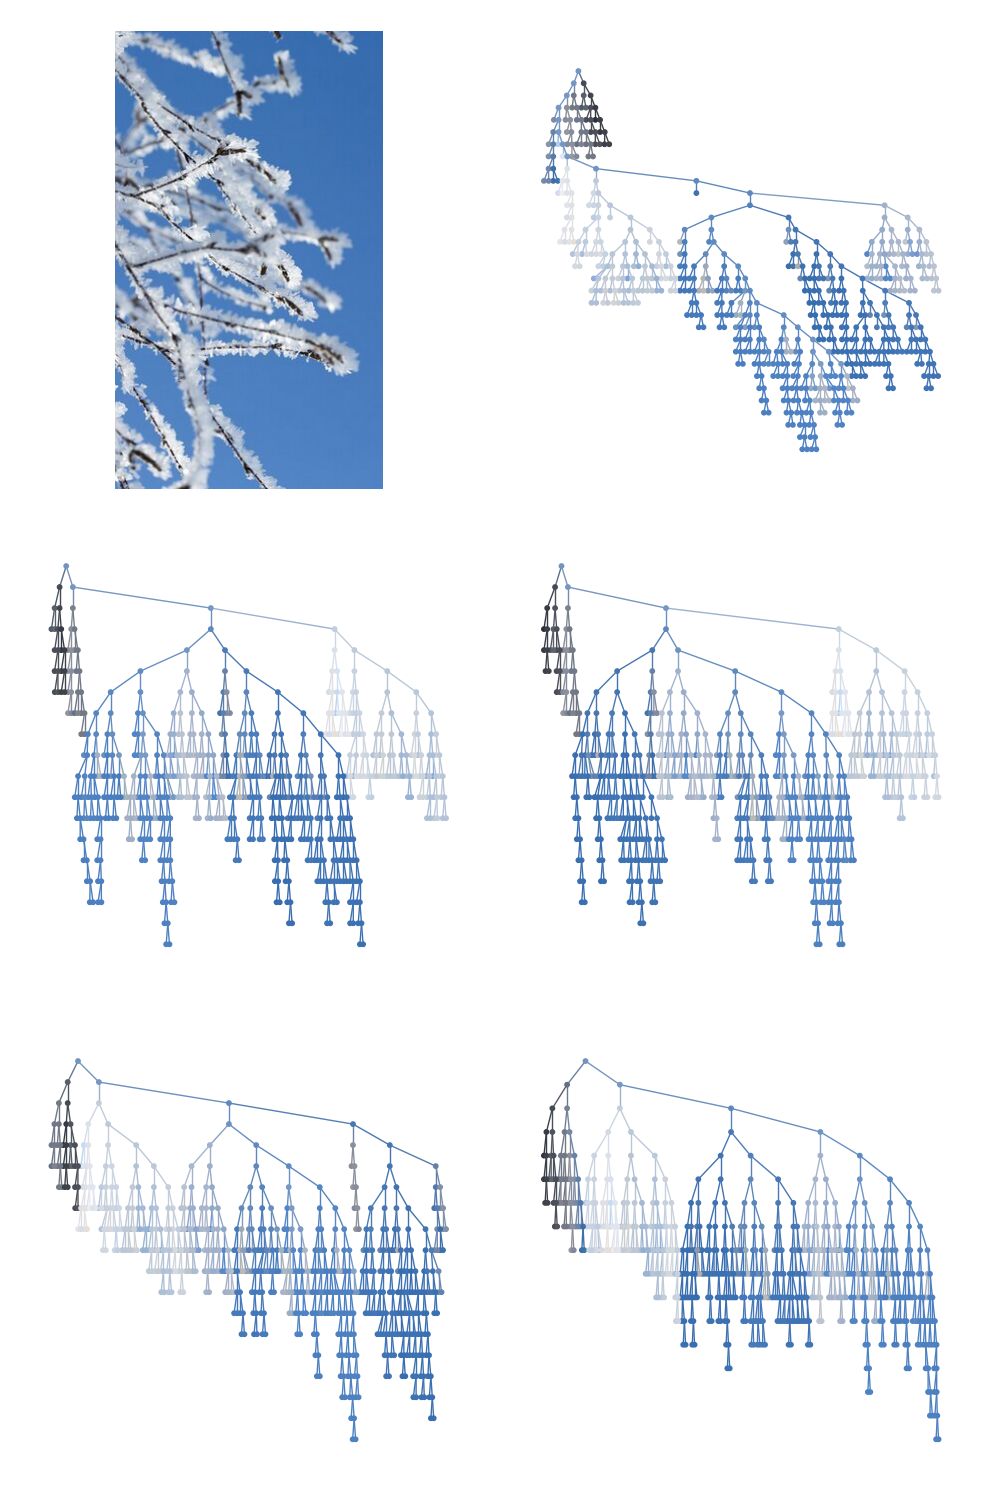

In [9]:
plot_nice_trees('./../data/winter_tree.png', 'winter_tree', reshape_factor=0.05, fig_size=5)

size:  456
done: single
done: centroid
done: avg
done: complete
done: ward


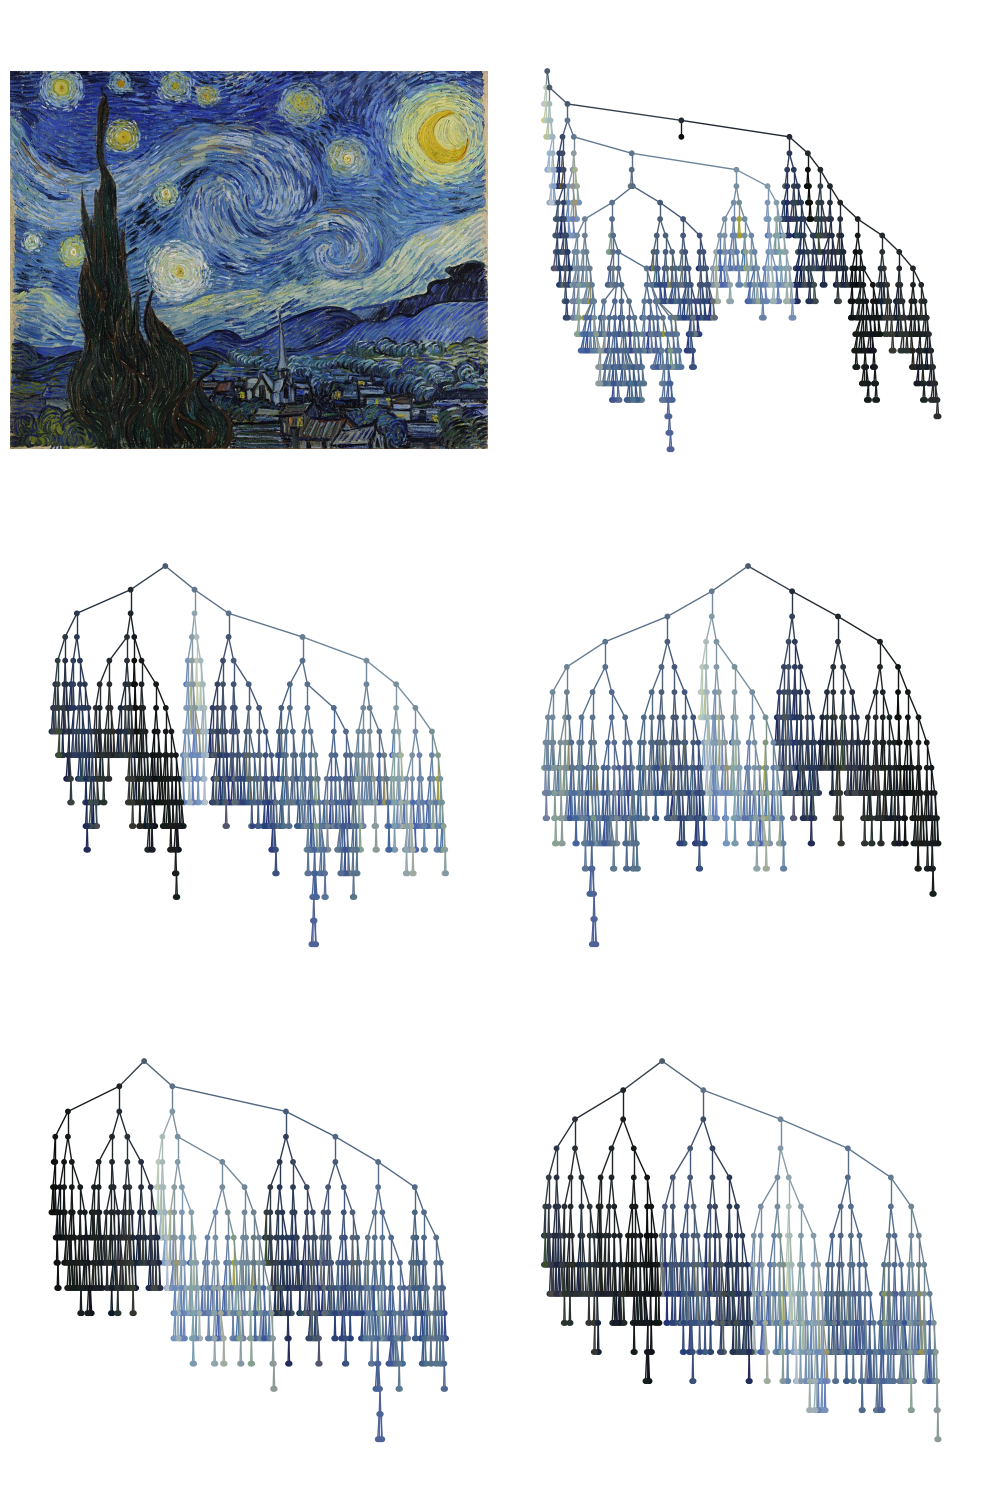

In [13]:
plot_nice_trees('./../data/starry_night.jpg', 'starry_night', reshape_factor=0.03, fig_size=5)